In [6]:
import json
from collections import defaultdict
from tqdm import tqdm
from typing import Dict, List, Tuple
from transformers import AutoModelForSequenceClassification, AutoTokenizer, BatchEncoding, PreTrainedTokenizerFast
from transformers.modeling_outputs import SequenceClassifierOutput
import torch

In [7]:
with open("/data/svashishtha/FAMuS/data/source_validation/train.jsonl") as f:
    train_source_val = [json.loads(line) for line in f.readlines()]

with open("/data/svashishtha/FAMuS/data/source_validation/dev.jsonl") as f:
    dev_source_val = [json.loads(line) for line in f.readlines()]

with open("/data/svashishtha/FAMuS/data/source_validation/test.jsonl") as f:
    test_source_val = [json.loads(line) for line in f.readlines()]

In [8]:
test_source_val[0].keys()

dict_keys(['instance_id', 'frame', 'report_dict', 'source_dict', 'valid_source', 'bool_generated'])

In [9]:
sum([1 for instance in test_source_val if instance['bool_generated']])

11

In [10]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/simlm-msmarco-reranker')
model = AutoModelForSequenceClassification.from_pretrained('intfloat/simlm-msmarco-reranker')
model.eval()
model = model.to(f'cuda:2')

In [11]:
def encode(tokenizer: PreTrainedTokenizerFast,
           query: str, passage: str, title: str = '-') -> BatchEncoding:
    return tokenizer(query,
                     text_pair='{}: {}'.format(title, passage),
                     max_length=512,
                     padding=True,
                     truncation=True,
                     return_tensors='pt')


def fetch_similarity(report_text, 
                     source_text,
                     similarity_model=None,
                     tokenizer=None,
                     gpu=1):
    with torch.no_grad():
        encoding = encode(tokenizer, report_text, source_text).to(f'cuda:{gpu}')
        output: SequenceClassifierOutput = similarity_model(**encoding)
        return output.logits[0][0].item()

## Positive Examples

In [12]:
train_source_val[0].keys()

dict_keys(['instance_id', 'frame', 'report_dict', 'source_dict', 'valid_source', 'bool_generated'])

In [19]:
pos_instances = [instance for instance in train_source_val + dev_source_val
                 if instance['valid_source']]
neg_instances = [instance for instance in train_source_val + dev_source_val
                    if not instance['valid_source']] 
    
len(pos_instances), len(neg_instances)


(1012, 1012)

In [20]:
pos_instances[0].keys()

dict_keys(['instance_id', 'frame', 'report_dict', 'source_dict', 'valid_source', 'bool_generated'])

In [21]:
# pos_instances[0]['report_dict']['doctext']

In [22]:
pos_sim_scores =   []
for instance in tqdm(pos_instances):
    pos_sim_scores.append(fetch_similarity(instance['report_dict']['doctext'],
                                            instance['source_dict']['doctext'],
                                              model, 
                                            tokenizer, gpu=2))

100%|██████████| 1012/1012 [00:29<00:00, 34.68it/s]


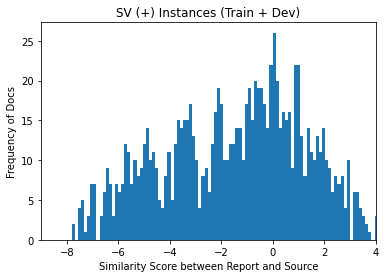

In [29]:
## Plot the distribution of similarity scores for positive instances
import matplotlib.pyplot as plt

plt.hist(pos_sim_scores, bins=100)
plt.xlabel('Similarity Score between Report and Source')
plt.ylabel('Frequency of Docs')
plt.xlim(-9, 4)
plt.title('SV (+) Instances (Train + Dev)')
# Save the figure before plt.show(), with desired resolution and format.
plt.savefig('histogram_simLM_positive_examples.png', format='png', dpi=300)
plt.show()

In [26]:
neg_sim_scores =   []
for instance in tqdm(neg_instances):
    neg_sim_scores.append(fetch_similarity(instance['report_dict']['doctext'],
                                            instance['source_dict']['doctext'],
                                              model, 
                                            tokenizer, gpu=2))

100%|██████████| 1012/1012 [00:29<00:00, 34.45it/s]


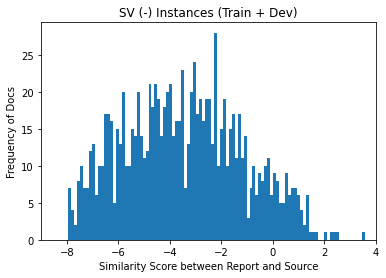

In [28]:
# Plot the distribution of similarity scores for negative instances
plt.hist(neg_sim_scores, bins=100)
plt.xlabel('Similarity Score between Report and Source')
plt.ylabel('Frequency of Docs')
plt.xlim(-9, 4)
plt.title('SV (-) Instances (Train + Dev)')
# Save the figure before plt.show(), with desired resolution and format.
plt.savefig('histogram_simLM_negative_examples.png', format='png', dpi=300)
plt.show()

In [31]:
instance.keys()

dict_keys(['instance_id', 'frame', 'report_dict', 'source_dict', 'valid_source', 'bool_generated'])

In [30]:
## distrubution of gold neg examples
gold_neg_instances = [instance for instance in train_source_val + dev_source_val
                    if not instance['valid_source'] and not instance['bool_generated']]

In [31]:
neg_gold_sim_scores =   []
for instance in tqdm(gold_neg_instances):
    neg_gold_sim_scores.append(fetch_similarity(instance['report_dict']['doctext'],
                                            instance['source_dict']['doctext'],
                                              model, 
                                            tokenizer, gpu=2))

100%|██████████| 472/472 [00:13<00:00, 35.35it/s]


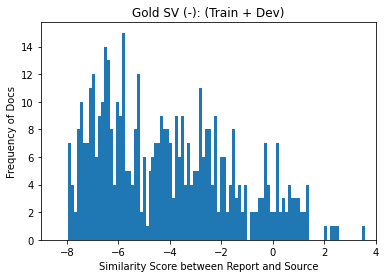

In [32]:
# Plot the distribution of similarity scores for negative instances
plt.hist(neg_gold_sim_scores, bins=100)
plt.xlabel('Similarity Score between Report and Source')
plt.ylabel('Frequency of Docs')
plt.xlim(-9, 4)
plt.title('Gold SV (-): (Train + Dev)')
# Save the figure before plt.show(), with desired resolution and format.
plt.savefig('histogram_simLM_gold_negative_examples.png', format='png', dpi=300)
plt.show()


In [33]:
## distrubution of generated neg examples
gen_neg_instances = [instance for instance in train_source_val + dev_source_val
                    if not instance['valid_source'] and instance['bool_generated']]
neg_gen_sim_scores =   []
for instance in tqdm(gen_neg_instances):
    neg_gen_sim_scores.append(fetch_similarity(instance['report_dict']['doctext'],
                                            instance['source_dict']['doctext'],
                                              model, 
                                            tokenizer, gpu=2))

100%|██████████| 540/540 [00:15<00:00, 34.26it/s]


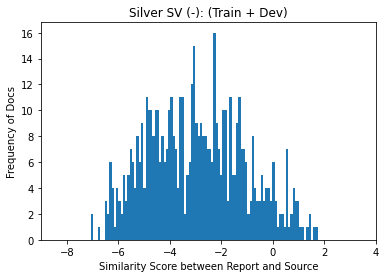

In [34]:
# Plot the distribution of similarity scores for negative instances
plt.hist(neg_gen_sim_scores, bins=100)
plt.xlabel('Similarity Score between Report and Source')
plt.ylabel('Frequency of Docs')
plt.xlim(-9, 4)
plt.title('Silver SV (-): (Train + Dev)')
# Save the figure before plt.show(), with desired resolution and format.
plt.savefig('histogram_simLM_silver_negative_examples.png', format='png', dpi=300)
plt.show()
